## RE-TRAINING THE FACENET MODEL USING BLACK-FACES

## The Arcface loss class

In [ ]:
import numpy as np

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.core import Dense, Activation, Lambda, Flatten
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.models import load_model
from keras.models import model_from_json
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

import matplotlib.pyplot as plt

In [2]:

from tensorflow import keras 

from keras import regularizers



# Original paper: https://arxiv.org/pdf/1801.07698.pdf
# Original implementation: https://github.com/deepinsight/insightface
# Adapted from tensorflow implementation: https://github.com/luckycallor/InsightFace-tensorflow

from keras import backend as K
from keras.layers import Layer
from keras.metrics import categorical_accuracy

import tensorflow as tf
import math as m


class ArcFace(Layer):
    '''Custom Keras layer implementing ArcFace including:
    1. Generation of embeddings
    2. Loss function
    3. Accuracy function
    '''

    def __init__(self, output_dim, class_num, margin=0.5, scale=64., **kwargs):
        self.output_dim = output_dim
        self.class_num = class_num
        self.margin = margin
        self.s = scale

        self.cos_m = tf.math.cos(margin)
        self.sin_m = tf.math.sin(margin)
        self.mm = self.sin_m * margin
        self.threshold = tf.math.cos(tf.constant(m.pi) - margin)
        super(ArcFace, self).__init__(**kwargs)


    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.class_num),
                                      initializer='glorot_normal',
                                      trainable=True)
        super(ArcFace, self).build(input_shape)  # Be sure to call this at the end


    def call(self, x):
        embeddings = tf.nn.l2_normalize(x, axis=1, name='normed_embeddings')
        weights = tf.nn.l2_normalize(self.kernel, axis=0, name='normed_weights')
        cos_t = tf.matmul(embeddings, weights, name='cos_t')
        return cos_t


    def get_logits(self, labels, y_pred):
        cos_t = y_pred
        cos_t2 = tf.square(cos_t, name='cos_2')
        sin_t2 = tf.subtract(1., cos_t2, name='sin_2')
        sin_t = tf.sqrt(sin_t2, name='sin_t')
        cos_mt = self.s * tf.subtract(tf.multiply(cos_t, self.cos_m), tf.multiply(sin_t, self.sin_m), name='cos_mt')
        cond_v = cos_t - self.threshold
        cond = tf.cast(tf.nn.relu(cond_v, name='if_else'), dtype=tf.bool)
        keep_val = self.s*(cos_t - self.mm)
        cos_mt_temp = tf.where(cond, cos_mt, keep_val)
        mask = tf.one_hot(labels, depth=self.class_num, name='one_hot_mask')
        inv_mask = tf.subtract(1., mask, name='inverse_mask')
        s_cos_t = tf.multiply(self.s, cos_t, name='scalar_cos_t')
        output = tf.add(tf.multiply(s_cos_t, inv_mask), tf.multiply(cos_mt_temp, mask), name='arcface_logits')
        return output


    def loss(self, y_true, y_pred):
        labels = K.argmax(y_true, axis=-1)
        logits = self.get_logits(labels, y_pred)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
        return loss


    def accuracy(self, y_true, y_pred):
        labels = K.argmax(y_true, axis=-1)
        logits = self.get_logits(labels, y_pred)
        accuracy = categorical_accuracy(y_true=labels, y_pred=logits)
        return accuracy
    

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)



### Alternative implementation of arcface

In [ ]:
from keras import backend as K
from keras.layers import Layer
from keras import regularizers

import tensorflow as tf


class ArcFace(Layer):
    def __init__(self, n_classes=10, s=30.0, m=0.50, regularizer=None, **kwargs):
        super(ArcFace, self).__init__(**kwargs)
        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.regularizer = regularizers.get(regularizer)

    def build(self, input_shape):
        super(ArcFace, self).build(input_shape[0])
        self.W = self.add_weight(name='W',
                                shape=(input_shape[0][-1], self.n_classes),
                                initializer='glorot_uniform',
                                trainable=True,
                                regularizer=self.regularizer)

    def call(self, inputs):
        x, y = inputs
        c = K.shape(x)[-1]
        # normalize feature
        x = tf.nn.l2_normalize(x, axis=1)
        # normalize weights
        W = tf.nn.l2_normalize(self.W, axis=0)
        # dot product
        logits = x @ W
        # add margin
        # clip logits to prevent zero division when backward
        theta = tf.acos(K.clip(logits, -1.0 + K.epsilon(), 1.0 - K.epsilon()))
        target_logits = tf.cos(theta + self.m)
        # sin = tf.sqrt(1 - logits**2)
        # cos_m = tf.cos(logits)
        # sin_m = tf.sin(logits)
        # target_logits = logits * cos_m - sin * sin_m
        #
        logits = logits * (1 - y) + target_logits * y
        # feature re-scale
        logits *= self.s
        out = tf.nn.softmax(logits)

        return out

    def compute_output_shape(self, input_shape):
        return (None, self.n_classes)


#### Importing the necessary packages

In [3]:
import tensorflow as tf
from tensorflow import keras 
from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.models import load_model

In [4]:
import os
from os import listdir

path="C:/Users/Diana/Desktop/Extracted/Training/"
count=0
for f in listdir(path):
  count=0
  for nome in listdir(path+f):
    count+=1
  print("Name: ",f,"count: ",count)




Name:  Alex count:  35
Name:  Aloyo count:  49
Name:  Apass count:  31
Name:  Barbie count:  25
Name:  Becky count:  39
Name:  Brian count:  39
Name:  Canary count:  39
Name:  Cindy count:  52
Name:  Daniel count:  77
Name:  Diana count:  62
Name:  Dorothy count:  26
Name:  Farid count:  73
Name:  Gaetanok count:  42
Name:  Gamzi count:  30
Name:  Julian count:  67
Name:  Kabareebe count:  53
Name:  Kabuura count:  23
Name:  Kanyomozi count:  79
Name:  Katamba count:  40
Name:  Katatumba count:  62
Name:  KenMugabi count:  59
Name:  Lucky count:  57
Name:  Lynda count:  54
Name:  Malaika count:  57
Name:  Marcus count:  45
Name:  Martha count:  43
Name:  Mcvex count:  50
Name:  Menk count:  56
Name:  Nabata count:  48
Name:  Nduhukire count:  54
Name:  Pesh count:  58
Name:  Raymond count:  21
Name:  Remuneration count:  71
Name:  Renal count:  26
Name:  Ruth count:  20
Name:  Samson count:  68
Name:  Vanny count:  38


In [5]:
import os
from os import listdir

path="C:/Users/Diana/Desktop/Extracted/Validation/"
count=0
for f in listdir(path):
  count=0
  for nome in listdir(path+f):
    count+=1
  print("Name: ",f,"count: ",count)

Name:  Alex count:  6
Name:  Aloyo count:  12
Name:  Apass count:  9
Name:  Barbie count:  4
Name:  Becky count:  10
Name:  Brian count:  7
Name:  Canary count:  17
Name:  Cindy count:  17
Name:  Daniel count:  17
Name:  Diana count:  11
Name:  Dorothy count:  3
Name:  Farid count:  17
Name:  Gaetanok count:  6
Name:  Gamzi count:  9
Name:  Julian count:  14
Name:  Kabareebe count:  10
Name:  Kabuura count:  8
Name:  Kanyomozi count:  12
Name:  Katamba count:  10
Name:  Katatumba count:  20
Name:  KenMugabi count:  14
Name:  Lucky count:  16
Name:  Lynda count:  11
Name:  Malaika count:  11
Name:  Marcus count:  9
Name:  Martha count:  9
Name:  Mcvex count:  8
Name:  Menk count:  10
Name:  Nabata count:  22
Name:  Nduhukire count:  8
Name:  Pesh count:  13
Name:  Raymond count:  6
Name:  Remuneration count:  21
Name:  Renal count:  8
Name:  Ruth count:  9
Name:  Samson count:  22
Name:  Vanny count:  14


#### Setting up the Image Data Generator API

In [6]:
#Import shutil first, this package deletes ipnb_checkpoints files that create a ghost class
import shutil
#The next step is to delete every ipynb_checkpoints file created by colab
#shutil.rmtree("/tmp/training/.ipynb_checkpoints") #be careful with shutil.rmtree() because it deletes every tree in that path. In other words, do not make mistakes.
#shutil.rmtree("/tmp/testing/.ipynb_checkpoints")

#specify both the training and validation directories
TRAINING_DIR="C:/Users/Diana/Desktop/Extracted/Training/"
VALIDATION_DIR="C:/Users/Diana/Desktop/Extracted/Validation/"

#Initialize Image Data Generator objects, and rescale the image 
training_datagen=ImageDataGenerator(rescale=1/255)
validation_datagen=ImageDataGenerator(rescale=1/255)

#Create the image generators that create the create the classes for all images uploaded
training_generator=training_datagen.flow_from_directory(TRAINING_DIR,class_mode='categorical',target_size=(160,160))
validation_generator=validation_datagen.flow_from_directory(VALIDATION_DIR,class_mode='categorical',target_size=(160,160))

#Load the facenet model architecture
#model=load_model('/tmp/facenet/facenet_keras.h5')


Found 1768 images belonging to 37 classes.
Found 430 images belonging to 37 classes.


## Loading the facenet Model architecture

In [7]:
model=load_model('C:/Users/Diana/Desktop/facenet_keras.h5')
#A summary of the model architecture
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

Block8_4_Activation (Activation (None, 3, 3, 1792)   0           Block8_4_ScaleSum[0][0]          
__________________________________________________________________________________________________
Block8_5_Branch_1_Conv2d_0a_1x1 (None, 3, 3, 192)    344064      Block8_4_Activation[0][0]        
__________________________________________________________________________________________________
Block8_5_Branch_1_Conv2d_0a_1x1 (None, 3, 3, 192)    576         Block8_5_Branch_1_Conv2d_0a_1x1[0
__________________________________________________________________________________________________
Block8_5_Branch_1_Conv2d_0a_1x1 (None, 3, 3, 192)    0           Block8_5_Branch_1_Conv2d_0a_1x1_B
__________________________________________________________________________________________________
Block8_5_Branch_1_Conv2d_0b_1x3 (None, 3, 3, 192)    110592      Block8_5_Branch_1_Conv2d_0a_1x1_A
__________________________________________________________________________________________________
Block8_5_B

In [8]:
print("Number of layers in the base model: ", len(model.layers))

Number of layers in the base model:  426


In [9]:
local_weights_file='C:/Users/Diana/Desktop/facenet_keras_weights.h5'
model.load_weights(local_weights_file)

for layer in model.layers:
  layer.trainable=False

In [10]:
from tensorflow.keras import layers
from tensorflow.keras import Model 

#Specify the last layer from the architecture, that you actually want
last_layer=model.get_layer('Bottleneck')
last_output=last_layer.output

In [ ]:
#Code from arcface repo
from keras.layers import Input
from keras.layers import BatchNormalization



#customizable arcface layer
#af_layer = ArcFace(output_dim=128, class_num=128, margin=0.5, scale=64.)




#Flatten the output layer to one dimension
x=layers.Flatten()(last_output)

af_layer = ArcFace(n_classes=128)[x]
#arcface_output = af_layer(last_output)
arcface_output=af_layer
print(arcface_output)
x=layers.Dense(1024,activation='relu')(arcface_output)
x=layers.Dense(512,activation='relu')(x)
x=layers.Dense(128,activation='relu')(x)
x=layers.Dense(15,activation='softmax')(arcface_output)




#We're temporarily adding a classification layer, for training purposes
#x=layers.Dense(15,activation='softmax')(x)
#x=layers.Dense(1024,activation='relu')(x)
#x=layers.Dense(128,activation='relu')(x)
#x=layers.Dense(15,activation='softmax')(x)

model=Model(model.input,x)

#Compiling the model using the RMSprop optimizer and categorical cross entropy loss
model.compile(optimizer=RMSprop(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

TypeError: ignored

### **Temporary Alternative to the above code cell**

In [18]:
#Code from arcface repo
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Dropout


#customizable arcface layer
af_layer = ArcFace(output_dim=128, class_num=128, margin=0.5, scale=64.)

arcface_output = af_layer(last_output)
x=layers.Flatten()(arcface_output)
#print(arcface_output)
x = Dropout(rate=0.3)(x)

x=layers.Dense(1024,activation='relu')(x)

x=layers.Dense(512,activation='relu')(x)
x = Dropout(rate=0.5)(x)
x=layers.Dense(128,activation='relu')(x)
x=layers.Dense(37,activation='softmax')(x)

model=Model(model.input,x)
model.compile(optimizer=RMSprop(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy',tf.keras.metrics.AUC(multi_label = True)])

In [19]:
from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    if epoch > 5:
        lr = 0.001
        return lr
    return lr


callbacks = [keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)]

In [20]:
checkpoint_filepath= 'C:/Users/Diana/Desktop/BestModel/checkpoint'
model_checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [21]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [22]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=10)

In [23]:
from keras.callbacks import ReduceLROnPlateau

In [24]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.0001)

In [25]:
#training for 100 epochs
history=model.fit(training_generator,validation_data=validation_generator,epochs=100,verbose=2, callbacks=[reduce_lr,early])

Epoch 1/100
56/56 - 264s - loss: 3.5619 - accuracy: 0.1210 - auc_1: 0.5924 - val_loss: 3.5024 - val_accuracy: 0.1907 - val_auc_1: 0.7262
Epoch 2/100
56/56 - 243s - loss: 3.4220 - accuracy: 0.1691 - auc_1: 0.7700 - val_loss: 3.3040 - val_accuracy: 0.2442 - val_auc_1: 0.8551
Epoch 3/100
56/56 - 272s - loss: 3.1983 - accuracy: 0.2076 - auc_1: 0.8403 - val_loss: 3.0315 - val_accuracy: 0.2884 - val_auc_1: 0.8963
Epoch 4/100
56/56 - 270s - loss: 2.9320 - accuracy: 0.2590 - auc_1: 0.8781 - val_loss: 2.7578 - val_accuracy: 0.3535 - val_auc_1: 0.9162
Epoch 5/100
56/56 - 266s - loss: 2.6645 - accuracy: 0.3281 - auc_1: 0.8993 - val_loss: 2.4974 - val_accuracy: 0.4535 - val_auc_1: 0.9274
Epoch 6/100
56/56 - 273s - loss: 2.4189 - accuracy: 0.4027 - auc_1: 0.9156 - val_loss: 2.2608 - val_accuracy: 0.5488 - val_auc_1: 0.9398
Epoch 7/100
56/56 - 273s - loss: 2.1721 - accuracy: 0.4808 - auc_1: 0.9305 - val_loss: 2.0476 - val_accuracy: 0.5651 - val_auc_1: 0.9461
Epoch 8/100
56/56 - 288s - loss: 1.9875 -

Epoch 61/100
56/56 - 288s - loss: 0.3410 - accuracy: 0.8988 - auc_1: 0.9962 - val_loss: 0.7912 - val_accuracy: 0.8023 - val_auc_1: 0.9751
Epoch 62/100
56/56 - 290s - loss: 0.3308 - accuracy: 0.8971 - auc_1: 0.9966 - val_loss: 0.7987 - val_accuracy: 0.7953 - val_auc_1: 0.9727
Epoch 63/100
56/56 - 280s - loss: 0.3487 - accuracy: 0.8976 - auc_1: 0.9952 - val_loss: 0.7962 - val_accuracy: 0.8000 - val_auc_1: 0.9752
Epoch 64/100
56/56 - 289s - loss: 0.3207 - accuracy: 0.9084 - auc_1: 0.9969 - val_loss: 0.8031 - val_accuracy: 0.8000 - val_auc_1: 0.9726
Epoch 65/100
56/56 - 284s - loss: 0.3252 - accuracy: 0.9033 - auc_1: 0.9969 - val_loss: 0.8193 - val_accuracy: 0.7884 - val_auc_1: 0.9712


In [26]:
print(tf.__version__)

2.4.1


In [27]:
print(keras.__version__)

2.4.0


### Lets visualize the output of the training phase

## 413 from 426

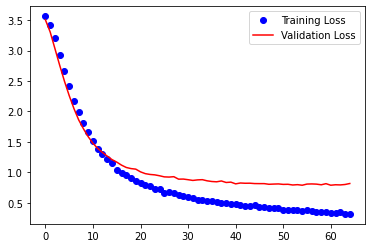

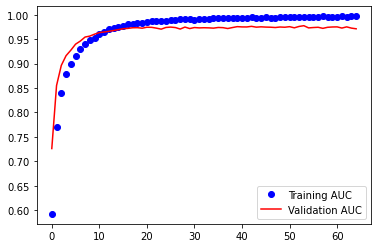

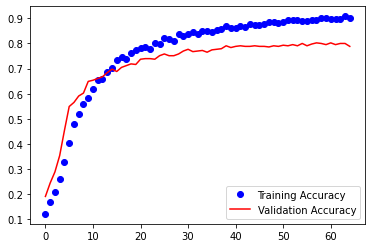

In [28]:
auc=history.history['auc_1']
val_auc=history.history['val_auc_1']

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

import matplotlib.pyplot as plt

plt.plot(epochs,loss,'bo',label="Training Loss")
plt.plot(epochs,val_loss,'r',label="Validation Loss")
plt.legend()
plt.show()


plt.plot(epochs,auc,'bo',label="Training AUC")
plt.plot(epochs,val_auc,'r',label="Validation AUC")
plt.legend()
plt.figure()

plt.plot(epochs,acc,'bo',label="Training Accuracy")
plt.plot(epochs,val_acc,'r',label="Validation Accuracy")
plt.legend()
plt.show()

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
____________________________________________________________________________________________

Block17_7_Branch_0_Conv2d_1x1_A (None, 8, 8, 128)    0           Block17_7_Branch_0_Conv2d_1x1_Bat
__________________________________________________________________________________________________
Block17_7_Branch_1_Conv2d_0c_7x (None, 8, 8, 128)    0           Block17_7_Branch_1_Conv2d_0c_7x1_
__________________________________________________________________________________________________
Block17_7_Concatenate (Concaten (None, 8, 8, 256)    0           Block17_7_Branch_0_Conv2d_1x1_Act
                                                                 Block17_7_Branch_1_Conv2d_0c_7x1_
__________________________________________________________________________________________________
Block17_7_Conv2d_1x1 (Conv2D)   (None, 8, 8, 896)    230272      Block17_7_Concatenate[0][0]      
__________________________________________________________________________________________________
Block17_7_ScaleSum (Lambda)     (None, 8, 8, 896)    0           Block17_6_Activation[0][0]       
          

Total params: 23,551,477
Trainable params: 743,717
Non-trainable params: 22,807,760
__________________________________________________________________________________________________


In [ ]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(96, 96))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [ ]:

def findCosineDistance(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

"""def l2_normalize(x):
    return x / np.sqrt(np.sum(np.multiply(x, x)))"""

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [ ]:
def displayImages(path1, path2):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(image.load_img(path1))
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    plt.imshow(image.load_img(path2))
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)

In [ ]:
p1 = 'openface-samples/katy-1.jpg'
p2 = 'openface-samples/katy-2.jpg'
p3 = 'openface-samples/miley-1.jpg'
p4 = 'openface-samples/miley-2.jpg'
p5 = 'openface-samples/angelina-1.jpg'
p6 = 'openface-samples/angelina-2.jpg'

In [ ]:
img1_representation = model.predict(preprocess_image(p1))[0,:]
img2_representation = model.predict(preprocess_image(p2))[0,:]
img3_representation = model.predict(preprocess_image(p3))[0,:]
img4_representation = model.predict(preprocess_image(p4))[0,:]
img5_representation = model.predict(preprocess_image(p5))[0,:]
img6_representation = model.predict(preprocess_image(p6))[0,:]

In [ ]:
img1_representation.shape

In [35]:
out_nodes = []

for i in range(len(model2.outputs)):
    out_nodes.append(out_prefix + str(i + 1))
    tf.identity(model2.output[i], out_prefix + str(i + 1))

NameError: name 'out_prefix' is not defined

In [34]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
sess=tf.Session()
from tensorflow.python.framework import graph_io
frozen = tf.graph_util.convert_variables_to_constants(sess, sess.graph_def, ["Bottleneck"])
graph_io.write_graph(frozen, '/tmp/session-frozens', 'inference_graph.pb', as_text=False)

AssertionError: Bottleneck is not in graph

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from keras import backend as K 
from keras.models import Sequential, Model


sess=tf.Session()
K.set_learning_phase(0)   # Set the learning phase to 0
model = model2 
config = model2.get_config()
#weights = model2.get_weights()
#model = Sequential.from_config(config)
output_node = model2.output.name.split(':')[0]  # We need this in the next step
graph_file = "kerasFacenet.pb" 
ckpt_file = "kerasFacenet.ckpt"
saver = tf.train.Saver(sharded=True)
tf.train.write_graph(sess.graph_def, '', graph_file)
#saver.save(sess, ckpt_file) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


'kerasFacenet.pb'

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

tf.saved_model.save(model2, "/tmp/saved-models")

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model2(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

layers = [op.name for op in frozen_func.graph.get_operations()]
#print("-" * 50)
#print("Frozen model layers: ")
for layer in layers:
    print(layer)

#print("-" * 50)
#print("Frozen model inputs: ")
#print(frozen_func.inputs)
#print("Frozen model outputs: ")
#print(frozen_func.outputs)

# Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="/tmp/saved-model",
                  name="facenet-Original-LastLayer.pb",
                  as_text=False)


INFO:tensorflow:Assets written to: /tmp/saved-models/assets
x
model_12/Conv2d_1a_3x3/Conv2D/ReadVariableOp/resource
model_12/Conv2d_1a_3x3/Conv2D/ReadVariableOp
model_12/Conv2d_1a_3x3/Conv2D
model_12/Conv2d_1a_3x3_BatchNorm/scale
model_12/Conv2d_1a_3x3_BatchNorm/ReadVariableOp/resource
model_12/Conv2d_1a_3x3_BatchNorm/ReadVariableOp
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3/ReadVariableOp/resource
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3/ReadVariableOp
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3/ReadVariableOp_1/resource
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3/ReadVariableOp_1
model_12/Conv2d_1a_3x3_BatchNorm/FusedBatchNormV3
model_12/Conv2d_1a_3x3_Activation/Relu
model_12/Conv2d_2a_3x3/Conv2D/ReadVariableOp/resource
model_12/Conv2d_2a_3x3/Conv2D/ReadVariableOp
model_12/Conv2d_2a_3x3/Conv2D
model_12/Conv2d_2a_3x3_BatchNorm/scale
model_12/Conv2d_2a_3x3_BatchNorm/ReadVariableOp/resource
model_12/Conv2d_2a_3x3_BatchNorm/ReadVariableOp
model_12/Conv2d_2a_3x

'/tmp/saved-model/facenet-Original-LastLayer.pb'